In [1]:
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                    #Alpaca library
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
import json                                             #JSON library ro work with JSON objects
from datetime import date                               #Data-Time library
import numpy as np                 

#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 
# Load .env enviroment variables
load_dotenv()
True
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')
    return alpaca
    


Bad key savefig.frameon in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
# # Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                        
    today = pd.Timestamp(today, tz="America/New_York").isoformat()  
    timeframe ='1Day'
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df
    portfolio.index = portfolio.index.date
    return portfolio
# function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})
    return symbol
# function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)
    closing_price = ticker[['close']]
    closing_price = closing_price.rename(columns={'close' : 'close'})
    return closing_price
# function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()
    data_cumulative = (1+data_returns).cumprod()
    return data_cumulative
# function for equally weghting stocks:
def equal_weights(data):
    weights = []
    for i in range(0,len(portfolio.columns)):
        w = 1/len(portfolio.columns)
        weights.append(w)
    return weights   


In [3]:
alpaca = setting_api()
tickers = ['APD', 'APH', 'RACE', 'TEL', 'IFF', 'GLW']
portfolio = portfolio_data(tickers)
portfolio.head()


,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-13,135.33,135.5800,134.17,134.30,626943,7518,134.705681,APD
2017-04-17,134.78,135.8950,134.42,135.86,1092375,11416,135.497295,APD
2017-04-18,135.04,136.0200,134.72,135.27,701020,10116,135.259170,APD
2017-04-19,135.73,136.0399,134.78,134.96,577819,7170,135.166924,APD
2017-04-20,135.62,137.3400,135.20,136.90,985329,10779,136.676759,APD


In [4]:
apd =format_data('APD')
aph =format_data('APH')
race=format_data('RACE')
tel=format_data('TEL')
iff=format_data('IFF')
glw=format_data('GLW')
apd.head()

,close
2017-04-13,134.30
2017-04-17,135.86
2017-04-18,135.27
2017-04-19,134.96
2017-04-20,136.90


In [5]:
portfolio = pd.concat([apd,aph,race,tel,iff,glw],axis =1,keys = ['APD','APH','RACE','TEL','IFF','GLW'])
portfolio.head()

,APD,APH,RACE,TEL,IFF,GLW
,close,close,close,close,close,close
2017-04-13,134.30,68.65,70.63,71.93,131.94,26.32
2017-04-17,135.86,69.53,71.32,72.77,133.02,26.54
2017-04-18,135.27,69.96,70.59,73.08,134.07,26.89
2017-04-19,134.96,70.12,71.26,73.18,134.53,26.86
2017-04-20,136.90,70.82,71.40,74.12,135.80,27.11


In [6]:
spy = bench_mark('SPY')
spy.head()

,SPY
2017-04-13,232.51
2017-04-17,234.57
2017-04-18,233.87
2017-04-19,233.44
2017-04-20,235.34


<AxesSubplot:>

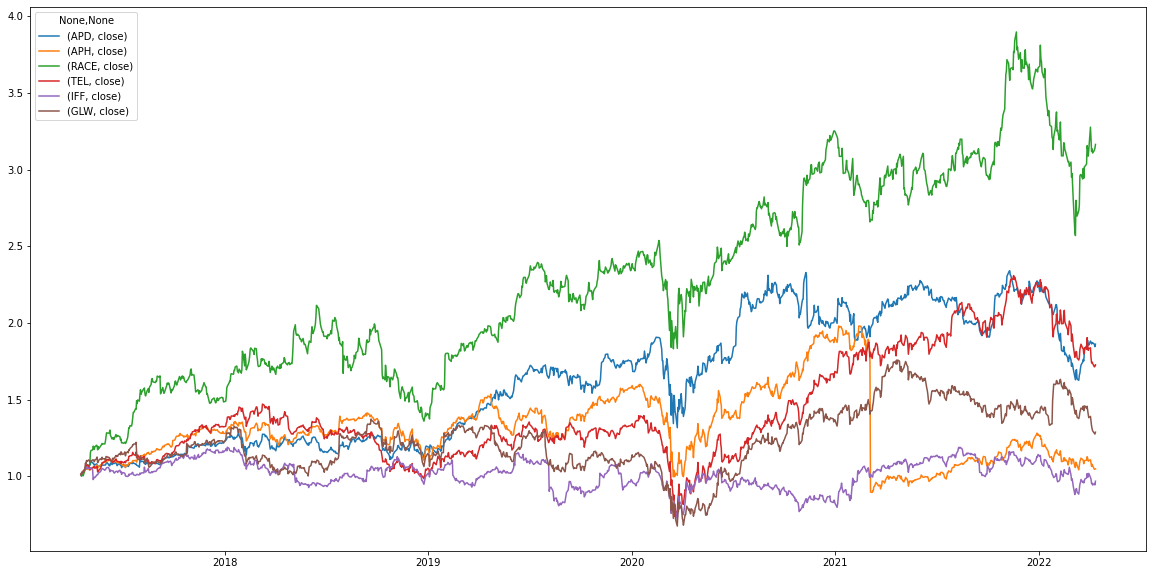

In [7]:
spy_cumulative = cumulative_returns(spy)
portfolio_cumulative = cumulative_returns(portfolio)
portfolio_cumulative.plot(figsize = (20,10))

<AxesSubplot:>

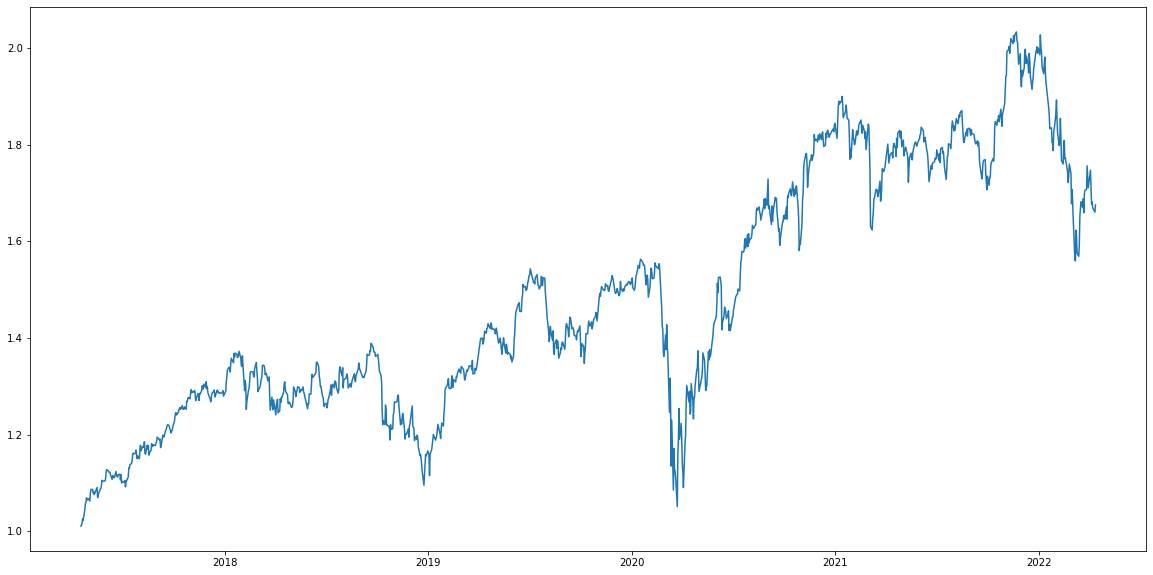

In [8]:
weights = equal_weights(portfolio)
portfolio_price_action = portfolio_cumulative.dot(weights)
portfolio_price_action.plot(figsize = (20,10))

In [9]:
#Concat the df and clean the data as well
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()
comparison = comparison.rename(columns = {0:'E.W Portfolio'})

<AxesSubplot:>

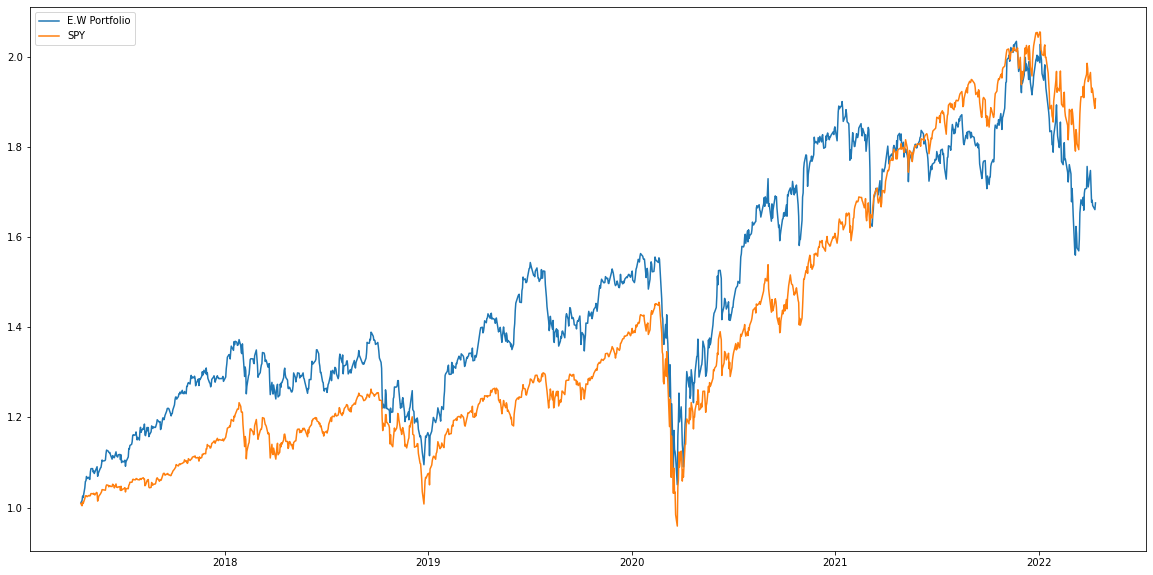

In [10]:
#Plot the comparison data
comparison.plot(figsize = (20,10))

In [11]:
#run Monte Carlos simulation 
sim_ew = MCSimulation(
    portfolio,
    weights=equal_weights(portfolio),
    num_simulation=1000,
    num_trading_days=252,
)

In [12]:
sim_ew.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\GitBash\Responsible_Investor\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995460,0.992193,1.024450,0.983212,0.995245,1.007124,0.996114,0.992030,1.011239,0.986515,...,1.006397,1.013640,1.005787,1.007121,1.011844,1.020941,1.007933,0.985296,0.987984,1.010503
2,0.992660,0.994016,1.015553,0.981123,0.995534,1.000660,0.997549,0.994113,1.028830,0.995952,...,0.997264,1.016379,1.013915,0.995401,1.011397,1.008366,0.995646,0.978191,0.975447,1.003189
3,0.996777,0.989345,1.015469,0.974537,0.978870,0.998005,0.986283,0.998921,1.017379,1.012127,...,0.985313,1.027685,1.019812,0.998771,1.024070,1.006268,1.005302,0.985190,0.984858,0.996081
4,1.007788,0.985399,1.014243,0.981424,0.979905,0.983028,0.983262,0.992793,1.015842,1.000337,...,0.976196,1.029311,1.023254,0.986471,1.026475,1.010040,1.000126,0.979845,0.973097,0.998564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1.185086,1.110767,1.160020,1.245133,1.143949,1.052267,1.214838,0.812296,1.136973,1.284124,...,1.118944,1.149472,1.107046,1.137934,1.336524,1.175755,1.095509,1.253815,1.117901,1.166183
249,1.183158,1.123805,1.149197,1.247348,1.147475,1.052404,1.200949,0.809634,1.137989,1.284726,...,1.123752,1.157046,1.107654,1.132101,1.342883,1.173470,1.091499,1.258441,1.120753,1.181401
250,1.187474,1.122541,1.145079,1.262283,1.150097,1.046874,1.209695,0.810053,1.141503,1.293383,...,1.110916,1.139071,1.104850,1.128526,1.356452,1.166126,1.089829,1.275009,1.131633,1.169087
251,1.188416,1.116224,1.137228,1.253266,1.147945,1.057088,1.212001,0.804423,1.131984,1.271799,...,1.108326,1.132455,1.100613,1.140187,1.367698,1.149764,1.096924,1.286398,1.129306,1.171176


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days.'}>

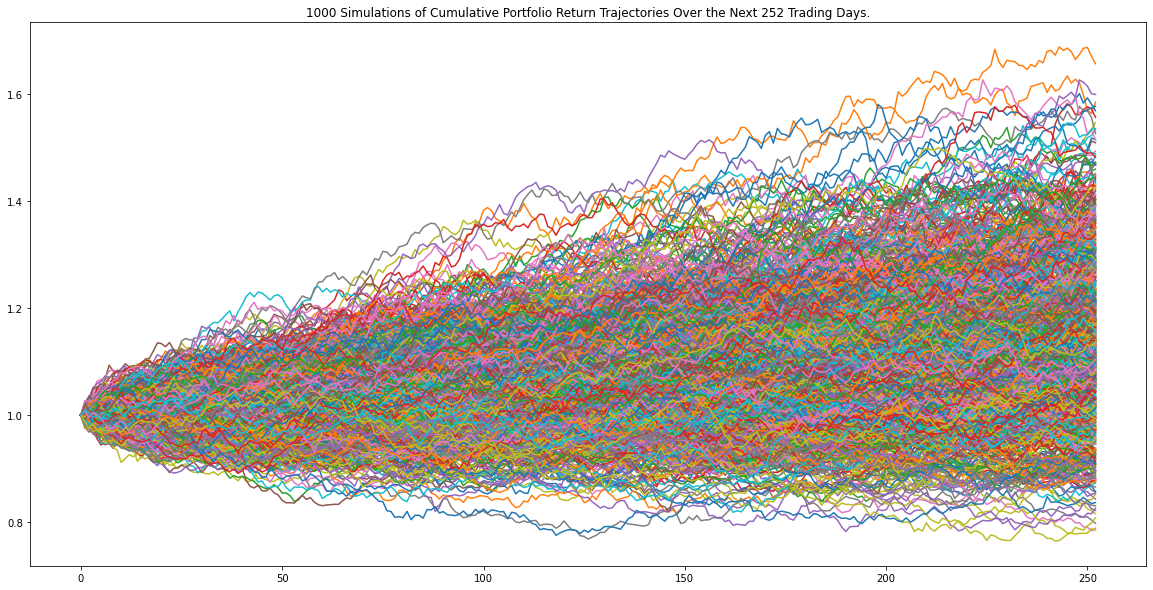

In [13]:
sim_ew.plot_simulation()

In [14]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = sim_ew.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

# Set initial investment
initial_investment = 20000

# Using lower & upper CI to calculate the `95%` confidence intervalsfor investment of $20,000
ci_lower = round(summary_stats[8] * initial_investment, 2)
ci_upper = round(summary_stats[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
      f" over a year will end within in the range of"
      f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")

count           1000.000000
mean               1.144777
std                0.144278
min                0.784936
25%                1.045827
50%                1.130695
75%                1.233674
max                1.657107
95% CI Lower       0.885793
95% CI Upper       1.452204
Name: 252, dtype: float64
There is a 95% chance that an initial investment of $20,000.00 in the portfolio over a year will end within in the range of $17,715.86 and $29,044.09


In [15]:
# Calculate volatility based on the MC stats
volatility = round(summary_stats[2] * np.sqrt(252) )
volatility

2

<AxesSubplot:title={'center':'Sharpe Ration'}>

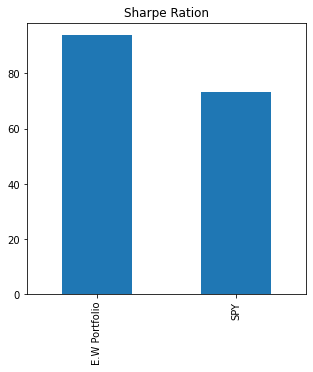

In [16]:
# Annualized Sharpe Ratios
annualized_sharpe_ratio = (comparison.mean() * 252) / (comparison.std() * np.sqrt(252))
annualized_sharpe_ratio
# Visualize the sharpe ratios as a bar plot
annualized_sharpe_ratio.plot(kind = "bar", title = "Sharpe Ration", figsize = (5,5))

In [33]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
from MCForecastTools import MCSimulation 

def f(m=0):
    if m > 0:
        sim_ew = MCSimulation(
                portfolio,
                weights=equal_weights(portfolio),
                num_simulation=10,
                num_trading_days=252*m)
        sim_ew.calc_cumulative_return()
    #display(sim_ew)
    
#interactive(description='A too long description')    
interactive(f, m=([5, 10, 15]))


interactive(children=(Dropdown(description='m', options=(5, 10, 15), value=5), Output()), _dom_classes=('widge…

In [47]:
#from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider

def t(Investment):
    # Fetch summary statistics from the Monte Carlo simulation results
    summary_stats = sim_ew.summarize_cumulative_return()

    # Set initial investment
    initial_investment = Investment

    # Using lower & upper CI to calculate the `95%` confidence intervalsfor investment of $20,000
    ci_lower = round(summary_stats[8] * initial_investment, 2)
    ci_upper = round(summary_stats[9] * initial_investment, 2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
          f" over a year will end within in the range of"
          f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")

h = widgets.Label('Choose your initial investment')
display(h)
interactive(t, Investment=([5, 10, 15]))
#interactive.description('A too long description')    


Label(value='Choose your initial investment')

interactive(children=(Dropdown(description='Investment', options=(5, 10, 15), value=5), Output()), _dom_classe…

In [30]:
from IPython.display import display
from ipywidgets import Dropdown

def dropdown_eventhandler(change):
    # Fetch summary statistics from the Monte Carlo simulation results
    summary_stats = sim_ew.summarize_cumulative_return()

    # Print summary statistics
    print(summary_stats)

    # Set initial investment
    initial_investment = change.new()

    # Using lower & upper CI to calculate the `95%` confidence intervalsfor investment of $20,000
    ci_lower = round(summary_stats[8] * initial_investment, 2)
    ci_upper = round(summary_stats[9] * initial_investment, 2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
          f" over a year will end within in the range of"
          f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")


option_list = (1, 2, 3)
dropdown = Dropdown(description="Choose one:", options=option_list)  #, value=None, disabled=False)
dropdown.observe(dropdown_eventhandler, names='value')
display(dropdown)


Dropdown(description='Choose one:', options=(1, 2, 3), value=1)

In [20]:
import ipywidgets as widgets

widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

In [21]:
print(dropdown.keys)

['_dom_classes', '_model_module', '_model_module_version', '_model_name', '_options_labels', '_view_count', '_view_module', '_view_module_version', '_view_name', 'description', 'description_tooltip', 'disabled', 'index', 'layout', 'style']
